# Código Base
link: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html

## Music Generation with RNNs

In [30]:
import tensorflow as tf 
import numpy as np
import os
import time
import regex as re
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from music21 import converter
import collections
# import subprocess
# import urllib
# import functools
import random

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

# devices = tf.config.list_physical_devices()
# tf.config.experimental.set_visible_devices(devices[0]) # fixa para executar na CPU (garante determinismo)

global_seed=301831
os.environ['PYTHONHASHSEED']=str(global_seed)
tf.keras.utils.set_random_seed(global_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()
os.environ['TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS'] = 'True'
# np.random.seed(global_seed)
# random.seed(global_seed)
# tf.random.set_seed(global_seed)





## Dataset

In [31]:
# def abc_filenames(datapath='abcnotation_midi-test', count=False):
#     songs = [os.path.join(datapath, f) for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]
#     if count==True:
#         print('Found {} songs in directory'.format(len(songs)))
#     return songs

# def abc_example():
#     songs = abc_filenames(count=True)
#     with open(songs[1], 'r') as f:
#         example_song = f.read()
#     print('\nExample Song: ')
#     print(example_song[1:-2])

# def join_songs(filenames):
#     songs = []
#     for filename in filenames:
#         f = open(filename,'r', encoding='utf8')
#         text = f.read()
#         songs.append(text[1:-2])
#     songs_joined = '\n\n'.join(songs)
#     return songs_joined  

# datapath = "./data/abcnotation"
# filenames = abc_filenames(datapath)
# songs = []
# for filename in filenames[0:5000]: 
#     try:
#             f = open(filename,'r', encoding='utf8')
#             text = f.read()
#             songs.append(text)
#             f.close()
#     except:
#         print("Erro em:", filename)
#         pass
    
# # print(len(songs))
# # print(len(filenames))

# example_song = songs[1]
# print("\nExample song: ")
# print(example_song)

In [32]:
def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    # print("Found {} songs in text".format(len(songs)))
    return songs

cwd = os.getcwd()

songs = []

with open(os.path.join(cwd, 'data', 'irish', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)



# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)


Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [33]:
def clean_abc(abc_song, show_rslt=False):
    # original .abc
    text = abc_song
    new_text = text

    # # remove index field
    # new_text = re.sub('(X:).*\n', '', new_text)

    # remove title field
    new_text = re.sub('(T:).*\n', '', new_text)

    # remove composer field
    new_text = re.sub('(C:).*\n', '', new_text)

    # remove source field
    new_text = re.sub('(S:).*\n', '', new_text)

    # remove geographical origin field
    new_text = re.sub('(O:).*\n', '', new_text)

    # remove textual notes field
    new_text = re.sub('(N:).*\n', '', new_text)

    # remove identity of transcriber/source of transcription field
    new_text = re.sub('(Z:).*\n', '', new_text)

    # remove lyrics
    new_text = re.sub('([wW]:).*\n','',new_text)

    # remove comments
    new_text = re.sub('(%).*\n','',new_text)

    if show_rslt==True:
        # print results
        print('original: '+str(len(text))+' characters'+'\n' + text)
        print()
        print('after modification: '+str(len(new_text))+' characters'+'\n' + new_text)

    return new_text

example_song2 = clean_abc(example_song)
print(example_song2)

X:1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [34]:
def extract_vocab(text):
    vocab = sorted(set(text))
    return {u:i for i, u in enumerate(vocab)}

for i in range(len(songs)):
    songs[i] = clean_abc(songs[i])

songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = extract_vocab(songs_joined)
print("There are", len(vocab), "unique characters in the dataset")

There are 64 unique characters in the dataset


## Process the dataset for the learning task

In [35]:
# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
#char2idx = {u:i for i, u in enumerate(vocab)}

def char2idx(string, vocab=None):
    if vocab==None:
        vocab = extract_vocab(string)
    vectorized_list = np.array([vocab[s] for s in string])
    return vectorized_list

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
#idx2char = np.array(vocab)

def idx2char(idx, vocab):
    keys = list(vocab.keys())
    string = ''
    if isinstance(idx, collections.Iterable):
        for i in idx:
            string += keys[i]
    else:
        string += keys[idx]
    return string

In [36]:
# print('{')
# count=0
# for char,val in zip(vocab.keys(), vocab.values()):
#     print('  {:4s}: {:3d}'.format(repr(char), val))
#     count +=1
#     if count == 19: 
#         print('  ...\n}')
#         break

In [37]:
'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

    NOTE: the output of the `vectorize_string` function 
    should be a np.array with `N` elements, where `N` is
    the number of characters in the input string
'''

# def vectorize_string(string):
#     vectorized_list = np.array([char2idx[s] for s in string])
#     return vectorized_list

vectorized_songs = char2idx(songs_joined, vocab)

In [38]:
# print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# # check that vectorized_songs is a numpy array
# assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

## Create training examples and targets

In [39]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1

  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1: i+1+seq_length] for i in idx]

  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch

def get_batch2(vectorized_song, seq_length, batch_size):
  n = len(vectorized_song) - 1

  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_song[i:i+seq_length] for i in idx]
  output_batch = [vectorized_song[i+1: i+1+seq_length] for i in idx]

  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch


vec_songs = [char2idx(song,vocab) for song in songs[0:2]]

seq_length = 10
batch_size = 2

x_batch = []
y_batch = []

for vec_song in vec_songs[0:2]:
  x, y = get_batch2(vec_song, seq_length, batch_size)
  x_batch.append(x)
  y_batch.append(y)

print(x_batch)
print()
print(np.squeeze(x_batch))

# for i, (input, output) in enumerate(zip(np.squeeze(x), np.squeeze(y))):
#   print("Step {:3d}".format(i))
#   print("  input: {} ({:s})".format(input, repr(idx2char(input, vocab))))
#   print("  expected output: {} ({:s})".format(output, repr(idx2char(output, vocab))))

[array([[45, 44, 45,  1, 30, 25, 45, 47, 63, 48],
       [45, 63,  6, 14, 46, 47, 46,  1, 45, 44]]), array([[63, 26, 13, 26, 31,  1, 44, 13, 44, 25],
       [13, 31, 25, 63, 26, 13, 26, 31,  1, 44]])]

[[[45 44 45  1 30 25 45 47 63 48]
  [45 63  6 14 46 47 46  1 45 44]]

 [[63 26 13 26 31  1 44 13 44 25]
  [13 31 25 63 26 13 26 31  1 44]]]


In [40]:
# x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

# x_batch

# for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
#     print("Step {:3d}".format(i))
#     print("  input: {} ({:s})".format(input_idx, repr(idx2char(input_idx, vocab))))
#     print("  expected output: {} ({:s})".format(target_idx, repr(idx2char(target_idx, vocab))))

## The Recurrent Neural Network (RNN) model

### Define the RNN model

In [41]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    tf.keras.layers.LSTM(
    units=rnn_units, 
    activation='tanh',
    recurrent_activation='sigmoid',
    recurrent_initializer='glorot_uniform',
    use_bias=True,
    bias_initializer='zeros',
    return_sequences=True, 
    stateful=True
    ),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
# model.weights

### Test out the model

In [42]:
# model.summary()

In [43]:
# x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
# pred = model(x)
# print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
# print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

### Prediction from the untrained model

In [44]:
# sampled_indices = tf.random.categorical(pred[0], num_samples=1)
# sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
# # sampled_indices

# print("Input: \n", repr("".join(idx2char(x[0], vocab))))
# print()
# print("Next Char Predictions: \n", repr("".join(idx2char(sampled_indices, vocab))))

### Training the model: loss and training operations

In [45]:
'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

# '''TODO: compute the loss using the true next characters from the example batch 
#     and the predictions from the untrained model several cells above'''
# example_batch_loss = compute_loss(y, pred) 

# print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [46]:
# # Optimization parameters:
# num_training_iterations = 2000  # Increase this to train longer
# batch_size = 4  # Experiment between 1 and 64
# seq_length = 100  # Experiment between 50 and 500
# learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# # Model parameters: 
# vocab_size = len(vocab)
# embedding_dim = 256 
# rnn_units = 512  # Experiment between 1 and 2048

# # Checkpoint location: 
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [47]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [48]:
# '''TODO: instantiate a new model for training using the `build_model`
#   function and the hyperparameters created above.'''
# model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

# '''TODO: instantiate an optimizer with its learning rate.
#   Checkout the tensorflow website for a list of supported optimizers.
#   https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
#   Try using the Adam optimizer to start.'''
# optimizer = tf.keras.optimizers.Adam(learning_rate)

# #@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

# ###################
# # Begin training! #
# ###################

# history = []
# plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
# if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# for iter in tqdm(range(num_training_iterations)):

#   # Grab a batch and propagate it through the network
#   x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
#   loss = train_step(x_batch, y_batch)

#   # Update the progress bar
#   history.append(loss.numpy().mean())
#   plotter.plot(history)

#   # Update the model with the changed weights!
#   if iter % 100 == 0:     
#     model.save_weights(checkpoint_prefix)
    
# # Save the trained model and the weights
# model.save_weights(checkpoint_prefix)

In [49]:
# Optimization parameters:
num_training_iterations = 2  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 10  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 512  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)
vec_songs = [char2idx(song, vocab) for song in songs]


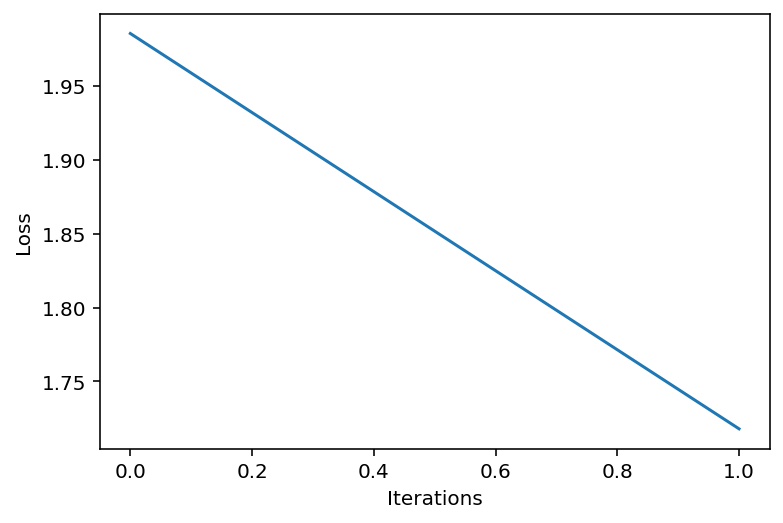

100%|██████████| 2/2 [01:02<00:00, 31.31s/it]


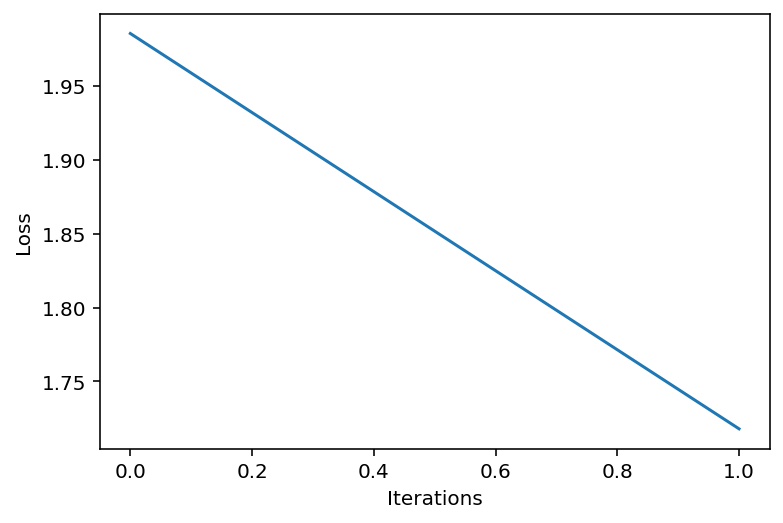

In [50]:
###################
# Begin training! #
###################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists


x_batch = []
y_batch = []
for vec_song in vec_songs:
    x, y = get_batch2(vec_song, seq_length, batch_size)
    x_batch.append(x)
    y_batch.append(y)

for iter in tqdm(range(num_training_iterations)):

  global_loss = []

  # Grab a batch and propagate it through the network
  for i in range(len(x_batch)):
    loss = train_step(x_batch[i], y_batch[i])
    global_loss.append(loss.numpy().mean())

  # Update the progress bar
  history.append(np.mean(global_loss))
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate music using the RNN model

### Restore the latest checkpoint

In [51]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

# model.summary()

### The prediction procedure

In [52]:
def generate_text(model, start_string, vocab=vocab, choose='length', generation_length=None, n_songs=None):
  input_eval = [char2idx(s, vocab) for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  if choose=='length':
    n = generation_length
    for i in tqdm(range(n)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char(predicted_id, vocab))
    
    text = (start_string + ''.join(text_generated))
  
  if choose=='n_songs':
    n = 0
    with tqdm(total=n_songs) as pbar:
      while n < n_songs:
        n0 = n
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char(predicted_id, vocab))
        text = (start_string + ''.join(text_generated))
        aux = extract_song_snippet(text)
        n = len(aux)
        if n > n0: 
          pbar.update(1)
    
  return text

In [53]:
n = len(songs[1]) 
n_train = round(0.8*len(songs[1]))
x_train = songs[1][0:n_train]
y_train = songs[1][n_train:n]


In [61]:
print(songs[1])
generated_text = generate_text(model, start_string=x_train, vocab=vocab, choose='length', generation_length=len(y_train))
# generated_text = generate_text(model, start_string="X:1\nT:", choose='n_songs', n_songs=10)
print(generated_text)

X:2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!


100%|██████████| 41/41 [00:00<00:00, 95.35it/s] 

X:2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG A2|B dc d2e|d3 dB dc D2D|G2F G >g=d gfe 


In [55]:
# generated_songs = extract_song_snippet(generated_text)
# print(generated_songs)
# print(len(generated_songs))

In [56]:
def save_song_abc(song, dir='./geradas/irish/', filename='gen'):
    save_name = dir+filename+'.abc'
    with open (save_name, 'w') as f:
        f.write(song)
        f.close()
    return save_name

def abc2midi(abc_song, dir='./geradas/irish/'):
    s = converter.parse(dir+abc_song+'.abc')
    s.write('midi', fp=dir+abc_song+'.mid')

# for i in range(len(generated_songs)):
#     save_song_abc(generated_songs[i], filename='gen'+str(i+1))
#     try:
#         abc2midi('gen'+str(i+1))
#     except: 
#         pass



In [57]:
save_song_abc(generated_text, filename='newgen')
abc2midi('newgen')

In [58]:
# caminhos
# - aparentemente, o código gera as músicas como deveria, mas sem reprodutibilidade...
# - inserir qualquer comando de fixar semente em "get_batch()" está dando problema
# - no entando, é possível fixar semente para peso inicial e para gerar caracteres/músicas dado o modelo com os pesos carregados (testar melhor)
# - talvez vale a pena criar alguns modelos deixando os pesos salvos, e gerar as músicas com base em uma seed determinada
# - talvez estabilizando o código, dê para realizar a computação na CPU para garantir reprodutibilidade
# próximos passos código
# - limpar/manipular arquivos ABC para brincar com predição
# - redefinir get_batch para limitar para cada arquivo .abc (objetivo: extrapolar cada música)
# - adaptar código para executar com dados do abcnotation, além do irish, claro